In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Hover Control
The state vector has the position and velocity vectors
$$
\mathbf{x}= \begin{bmatrix}
 \mathbf{p}
\\ 
\mathbf{\dot p}
\end{bmatrix}.
$$

The dynamics is described by the differential equation
$$
\mathbf{\dot x} = \begin{bmatrix}
\mathbf{\dot p}\\
-mg\mathbf{e}_3
\end{bmatrix}
+
\begin{bmatrix}
 \mathbf{0}
\\ 
\mathbf{e}_3
\end{bmatrix}
u
.
$$
where $\mathbf{e}_3= [0,0,1]^\top$.

### Euler integration

In [2]:
def simulate(Δt, x, u):
    x += Δt * u
    return x

### Simulation parameters

In [3]:
# mass and gravity
m, g = 1, 9.8
# z unit vector
e3 = np.array([0,0,1])

tf = 6.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

# Simulation 

In [4]:
# Desired high
z_d = 10
vz_d = 0

# Gains
kp, kd = 2, 3

# Initial conditions
x = np.array([0,0,0, 0., 0., 0.])
dx = np.zeros(6)

x_log = [copy(x)]

for t in time[1:]:
    z = x[2]
    vz = x[5]
    
    # Total force 
    f_g = -m*g*e3
    
    u = kp*(z_d - z) + kd*(vz_d - vz) + g
    
    # Dynamics
    dx[:3] = x[3:]
    dx[3:] = f_g / m + u * e3
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    
x_log = np.array(x_log)

### Plot: time Vs z-coordinate

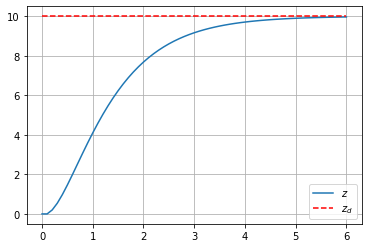

In [5]:
grid()
plot(time, x_log[:,2], label='$z$')
# desired
plot(time[[0,-1]], [z_d, z_d], 'r--', label='$z_d$')
legend()

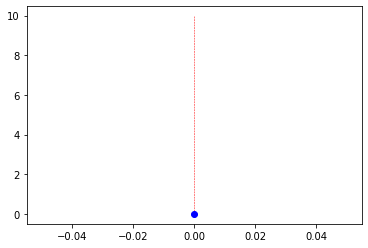

In [6]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()


def animate(t):
    ax.clear()
    
    # Path
    ax.plot(x_log[:,0], x_log[:,2], 'r--', linewidth=0.5)
    
    # Initial conditions
    ax.plot(x_log[t,0], x_log[t,2], 'bo')
        

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)
HTML(anim.to_jshtml())



# Orientation Control
The state vector has the position and velocity vectors
$$
\mathbf{x}= \begin{bmatrix}
 \mathbf{\theta}
\\ 
\mathbf{\dot \theta}
\end{bmatrix}.
$$

The dynamics is described by the differential equation
$$
\mathbf{\dot x} = 
\begin{bmatrix}
 {0}
\\ 
1
\end{bmatrix}
u
.
$$
where $\mathbf{e}_3= [0,0,1]^\top$.


Dynamics
$$
\omega {I_y} = \tau_y
$$
The propeller forces
$$
\tau = [-l, l] [f_1, f_2]^\top
$$
Then
$$
f_i = \frac{\tau}{2l}
$$


### Euler integration

In [7]:
def simulate(Δt, x, dx):   
    x += Δt * dx
    return x

### Simulation parameters

In [8]:
# z unit vector
e3 = np.array([0,0,1])

tf = 6.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

# Simulation 

In [53]:
# Desired angle
θ_d = -pi
ω_d = 0

# Gains
kp, kd = 2, 3

# arm
l = 1
Iy = 1

# Initial conditions
x = np.array([0.,0.])
dx = np.zeros(2)

x_log = [copy(x)]
u_log = [[0,0]]

for t in time[1:]:
    θ = x[0]
    ω = x[1]
    
    # PD controller         
    a = kp*(θ_d - θ) + kd*(ω_d - ω) # dessired angular acceleration
    
    ## Torque
    τ = Iy * a
    # forces u=iA.w
    u = [-τ / (2*l), τ / (2*l)]
    # acceleration in the body frame
    a = np.dot([-l,l], u)
    # Convert acceleration to the world frame a=I.a
    
    
    # Dynamics
    dx[0] = x[1]
    dx[1] = a
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(copy(u))
    
x_log = array(x_log)
u_log = array(u_log)

### Plot: time Vs $\theta$

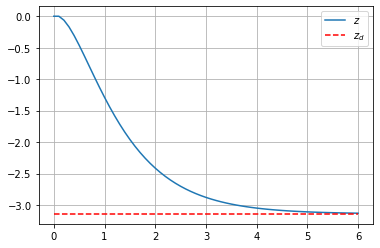

In [54]:
grid()
plot(time, x_log[:,0], label='$z$')
# desired
plot(time[[0,-1]], [θ_d, θ_d], 'r--', label='$z_d$')
legend()

## Draw simple box

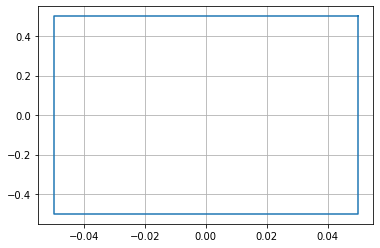

In [55]:
def box_points(w, h):
    points = np.zeros([5,3])
    points[0] = [ + w/2, 0, + h/2]
    points[1] = [ + w/2, 0, - h/2]
    points[2] = [ - w/2, 0, - h/2]
    points[3] = [ - w/2, 0, + h/2]
    points[4] = [ + w/2, 0, + h/2]
    return points

box = box_points(0.1, 1)  

plot(box[:,0], box[:,2])
grid()


### Box in SE(2)

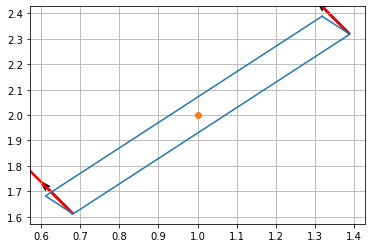

In [60]:
def box_se2(x, z, θ, u=[0,0], w=1, h=.1, ax=plt.axes()):
    points = box_points(w, h)
    # Rotation matrix
    R = [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]
    # Rotate
    points = [np.dot(R, p) for p in points]    
    points = array(points)
    
    # translate
    points[:,0] += x
    points[:,2] += z
    
    
    # propellers
    e1 = [1,0,0]    
    prop_x = array([sin(θ), sin(θ)])
    prop_z = array([cos(θ), cos(θ)])
        
    # Plot propellers
    px = points[1:3,0]
    pz = points[1:3,2]
    ax.quiver(px, pz, prop_x, prop_z, scale=7)
    
    ax.plot(points[:,0], points[:,2])
    # control input    
    ax.quiver(px, pz, u*prop_x, u*prop_z, scale=7, color='r')
    
 
x, z, θ = 1,2, -pi/4
box_se2(x, z, θ, [3,3], w=1, h=0.1)

plot(x,z, 'o')
grid()

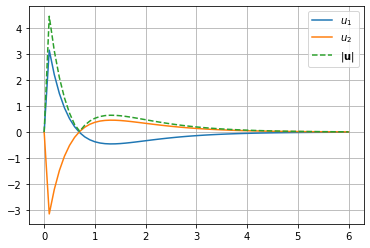

In [63]:
# Control inputs
u_log = array(u_log)
for i in range(2):
    plot(time, u_log[:,i], label='$u_%d$'%(i+1))
plot(time, np.linalg.norm(u_log, axis=1), '--',label='$\| \mathbf{u}\|$')
grid()
legend()

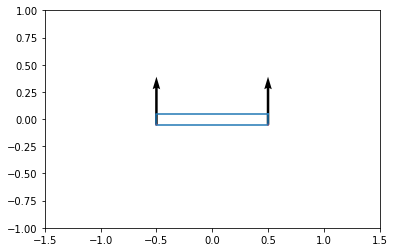

In [61]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()


def animate(t):
    ax.clear()       
        
    θ = x_log[t,0]
    u = u_log[t]
    # box points
    box = box_se2(0, 0, θ, u, w=1, h=0.1, ax=ax)

 
    # Initial conditions
    #ax.plot(t, x_log[t,0],  'bo')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.,1.))
    

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)
HTML(anim.to_jshtml())

